<img src="img/logo_wiwi_en_.png" width="30%" align="left">

<img src="img/decision_analytics_logo.png" width="17%" align="right">



<br><br><br><br><br><br><br><br>



# Combining OR and Data Science

**Summer Term 2023**


# 6. Optimization under Uncertainty II:  Risk Aversion and Chance-Constrained Programming


<br>

<br>
<br>

**J-Prof. Dr. Michael Römer, Till Porrmann, Mohsen Nafar**

**Decision Analytics Group  | Bielefeld University**
                                                    


In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numba import vectorize
import pandas as pd
import mip
from mip import maximize
from scipy.optimize import minimize

## Overview

#### Part I:  Risk Orientation / Decision-Making as Shaping Distributions

- Shaping Distributions by Incorporating Risk Attitude into Decision / Optimization Models

#### Part II: Feasibility Guarantees by Chance-Constrained Programming
- Feasibility Issues in Single-Stage Problems under Uncertainty
- Single Chance Constraints
- Joint Chance Constraints


# Part I: Risk Orientation and Decision Making under Uncertainty as Shaping Distributions

## Part I: Risk Orientation and Decision Making under Uncertainty as Shaping Distributions

In the first part, we will introduce the idea that:

**Decision Making under Uncertainty means Shaping Distributions**

In particular, we will answer the following questions:
- when it is appropriate to optimize expected values?
- what is an outcome distribution?
- what kind of useful information does the outcome distribution give us?
- how can we compare outcome distributions?
- how can we modify models to account for risk attitude?

## Literature

Much of the literature dealing with Stochastic Programming is not very accessible for Business students. In my opinion, the following book is an exception:
- **Modeling with Stochastic Programming**, Authors: Alan King and Stein Wallace, Springer, 2012 

Other Textbooks include:
- **Introduction to Stochastic Programming** (2nd edition), Authors: John Birge and Francois Louveaux, Springer, 2011
- **Stochastic Programming: Modeling Decision Problems Under Uncertainty**,  Authors: Klein Haneveld et al. , Springer, 2020 


*Note that these Springer textbooks are available as full text pdfs from the university library!*


## This Meeting: The Outcome Distribution and Risk Orientation in Stochastic Programming

**In this meeting, we will**
- discuss how to obtain the outcome distribution
- see how manipulate the outcome distribution to account for risk aversion by:
    - penalizing shortfalls
    - mean-risk optimization with Conditional Value at Risk
- we will use the agricultural case study  for illustration and exercises


## Review: A Stochastic Programming Formulation for our Case Study

**Sets:**
- $S$  scenario set

**Parameters:**
- $d_s$: demand in units in scenario  $s$
- $p_s$: probability of scenario $s$

**Decision Variables:**
- $x$: capacity installation decision (*first stage* / *here and now* decision) 
- $z_s$: production decision for scenario $s$ (*second stage* / *recourse* decision)


 \begin{align*}
        \max \;        -30x +  & \sum_{s \in S} p_s 40 z_s \\
        \text{s.t.} \qquad   z_s &\leq x \qquad &\forall s \in S \\                  
                         z_s &\leq d_s \qquad &\forall s \in S \\
                         x &\geq 0 \\
 z_s &\geq 0 \qquad &\forall s \in S
\end{align*}

## Review: Implementation in Python


In [4]:
demand_dist = stats.norm(100,25)

n_samples = 10000

# we create a sample vector of demands (demand_dist was defined above), only using positive outcomes
demand_sample = np.maximum(demand_dist.rvs(n_samples),0)

In [6]:

# Create a new model
m = mip.Model("Capacity_Planning_Stochastic")

#sets
n_scenarios = n_samples
scenarios = np.arange(n_scenarios) #in stochastic programming, we call the samples scenarios

#probability of each scenario - in our case, each scenario has prob. 1/|S|
prob = np.full((n_scenarios), 1/n_scenarios)

#parameters
installation_cost = 30
contribution_margin = 40

#decision variables
capacity =  m.add_var(name="capacity", lb=0)

production = [m.add_var(name=f"production{s}", lb= 0) for s in scenarios]

m.objective =  maximize( -installation_cost*capacity + sum(prob[s] * contribution_margin * production[s] for s in scenarios))

for s in scenarios:    
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 

m.optimize()

print(f'Capacity decision: {capacity.x:.02f}')

print(f'Expected Total Profit: {m.objective_value:.02f}' )

Capacity decision: 82.87
Expected Total Profit: 678.17


# The Outcome Distribution in Stochastic Programming

## Model Reformulation for Obtaining the Outcome Distribution

**Remember:** Decision making under uncertainty means shaping distributions
- Where is the outcome distribution in a stochastic program?

**Idea:** Introduce an outcome variable **$g_s$** per scenario (a second-stage variable) and reformulate the model as follows:



\begin{align*}
        \max \;      &\sum_{s \in S} p_s g_s \\
        \text{s.t.} \qquad g_s &=  -30x +  40 z_s  \qquad &\forall s \in S\\
        z_s &\leq x \qquad &\forall s \in S \\                  
                         z_s &\leq d_s \qquad &\forall s \in S \\
                         x &\geq 0 \\
 z_s &\geq 0 \qquad &\forall s \in S
\end{align*}

In a given solution:

- the vector $\mathbf{g}=[g_s]_{s \in S}$ is a sample approximation of the outcome (total profit) distribution given the optimal capacity decision $x$


## Model Reformulation for Obtaining the Outcome Distribution

**Remember:** Decision making under uncertainty means shaping distributions
- Target value is $g^t$

**Idea:** Introduce an outcome variable **$g_s$** per scenario (a second-stage variable) and reformulate the model as follows:



\begin{align*}
        \max \;      &\sum_{s \in S} p_s( g_s - \lambda v_s)\\
        \text{s.t.} \qquad g_s &=  -30x +  40 z_s  \qquad &\forall s \in S\\
        z_s &\leq x \qquad &\forall s \in S \\   
        v_s & \geq g^t - g_s \qquad &\forall s \in S \\  
                         z_s &\leq d_s \qquad &\forall s \in S \\
                         x &\geq 0 \\
 z_s &\geq 0 \qquad &\forall s \in S \\
 v_s &\geq 0 \qquad &\forall s \in S \\ 
\end{align*}

In a given solution:

- the vector $\mathbf{g}=[g_s]_{s \in S}$ is a sample approximation of the outcome (total profit) distribution given the optimal capacity decision $x$


## Model Reformulation: Implementation in Python

In [7]:
# Create a new model
m = mip.Model("Capacity_Planning_Stochastic")

#decision variables
capacity =  m.add_var(name="capacity", lb=0)

production = [m.add_var(name=f"production{s}",lb=0) for s in scenarios]

## this is the new variable
profit = [m.add_var(name=f"profit{s}",  lb=-np.inf) for s in scenarios]

m.objective =  maximize( sum(prob[s] * profit[s] for s in scenarios)) 

for s in scenarios:   
    m += profit[s] == -installation_cost*capacity + contribution_margin * production[s] # computes the profit for scenario s
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 

m.optimize()

print(f'Capacity decision: {capacity.x:.02f}')
print(f'Expected Total Profit: {m.objective_value:.02f}' )




Capacity decision: 82.87
Expected Total Profit: 678.17


## Plotting the Outcome Distribution

As ab example, we can now  use the vector $\mathbf{g}=[g_s]_{s \in S}$ from the optimal solution plot a histogram of the outcompe distribution:

Text(0.5, 0, 'Total Profit')

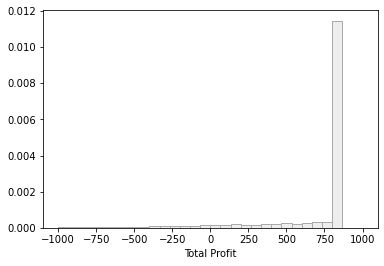

In [8]:
## collect the profit samples into an array
profit_samples = np.array( [ profit[s].x for s in scenarios ])

count, bins, ignored = plt.hist(profit_samples, bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA", range =[-1000,1000])
plt.xlabel('Total Profit')

#plt.savefig('profit_distribution_stochastic_lp.pdf')


#  Risk Attitude and Shaping Distributions

##  Risk Attitude and Shaping Distributions

Recall that **decision making under uncertainty means shaping outcome
distributions**

- if the decision maker is risk averse, optimizing the expected value is not the best idea
- we may thus take the outcome distribution into account by
  introducing scenario-dependent outcome variables
- and we can change the objective function and add constraints to
  reflect the risk attitude of decision makers

We will consider the following approaches for **incorporating risk aversion into stochastic programs**:
- target values and shortfall penalties
- mean-risk objectives using CVaR as risk measure



##  Targets and Shortfall Penalties

**Key Idea**:
- set a target, e.g.  $g^t$
- introduce a shortfall variable $v_s$ for each scenario $s$
- in the objective, penalize expected shortfall   with factor $\lambda$


**Model:**



 \begin{align*}
        \max \;        &\sum_{s \in S}  p_s g_s  - \lambda  \sum_{s \in S} p_s v_s \\
        \text{s.t.} \qquad   g_s &=  -30x +  40z_s\qquad &\forall s \in S \\  
	   v_s &\geq g^t - g_s    &\forall s \in S \\  
                         z_s &\leq d_s \qquad &\forall s \in S \\
         z_s &\leq x \qquad &\forall s \in S \\                  
                         x &\geq 0 \\
			 v_s &\geq 0, z_s \geq 0 \qquad &\forall s \in S			 
\end{align*}


##  Targets and Shortfall Penalties: Implementation in Python



In [11]:
target_value = 500
lambd = 0.5

# Create a new model
m = mip.Model("Capacity_Planning_Stochastic_Shortfall")

#decision variables
capacity =  m.add_var(name="capacity", lb=0)
production = [m.add_var(name=f"production{s}",lb=0) for s in scenarios]

## this is the profit variable (scenario-dependent)
profit = [m.add_var(name=f"profit{s}",  lb=-np.inf) for s in scenarios]

## this is the shortfall variable (scenario-dependent)
shortfall = [m.add_var(name=f"shortfall{s}",  lb=0) for s in scenarios] # scenario-dependent!

# in the objective, we now add a variable for the shortfall
m.objective =  maximize( sum(prob[s] * profit[s] for s in scenarios)  - lambd*sum( prob[s]*shortfall[s] for s in scenarios ) ) 

for s in scenarios:   
    m += profit[s]  == -installation_cost*capacity + contribution_margin * production[s] # computes the profit for scenario s
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 
    # computing shortfall
    m += shortfall[s] >= target_value - profit[s]

m.optimize()

print(f'Results for a target {target_value} and lambda = {lambd}')
print(f'Capacity decision: {capacity.x:.02f}')
print(f'Objective function value: {m.objective_value:.02f}' )

profit_samples = np.array( [ profit[s].x for s in scenarios ])
print(f' Expected Profit: {np.mean(profit_samples):.02f}')


Results for a target 500 and lambda = 0.5
Capacity decision: 78.90
Objective function value: 640.64
 Expected Profit: 674.16


# Part II: Chance-Constrained Programming

## Motivation

In our case studies discussed so far, we assumed that there are second-stage decisions:
- Capacity Planning: adapting production to demand
- Farmer's problem: buying and selling crops on the market

**What if we assume that we cannot react?**
- we will either have enforce a safe solution
- or tolerate a certain violation
- in many setting, we may see this as a **service level**
  - for example, on-time guarantees in logistics

## Chance-Constrained Programming: Overview


In this part, we learn how to create optimization models
under uncertainty providing probabilistic guarantees

**In particular, we will discuss**
- how to model cases in which a single constraints are affected by
  uncertainty using **chance constraints**
- how to model **joint chance constraints** providing a feasibility
  guarantee for problems in which multiple constraints are affected by
  uncertainty
- how to **improve joint chance constraint formulations** to make then solvable faster

 


# Belt Manufacturing Case Study as an Illustration

## Case Study: Manufacturing Belts

- A small company manufactures two types of belts: A  and B. The contribution margin  \\$2 for an A-belt and \\$1.5 for a B-belt.
- It plans the production for a week, and it can sell its full production to small chain of shops.
- Producing a belt of type A takes twice as long as producing one of
  type B, and the total time available in that week would allow
  producing 1000 belts of type B if only B-belts were produced.
- Both types of belts require the same amount of leather, and there is enough leather to produce 800 belts.
- The total number that can be produced per type is limited by the number of available bucks: The company has 400 bucks for type A and 700 bucks for type B.

Create an LP model that determines the number of belts from each type to produce if the shop aims at maximizing the total contribution margin!

## Case Study: Manufacturing Belts - Deterministic LP

**Set**
- $I = \{A,B\}$ belt types

**Decision Variables**
- $x_i$: number of belts to produce from type $i$

\begin{align*}
        \max \;          2x_A +1.5x_B  \\                  
        \text{s.t.} \;   2x_A + x_B &\leq 1000 \\
		    	   x_A + x_B &\leq 800 \\
		    	   0 \leq x_A &\leq 400 \\
		    	   0 \leq x_B &\leq 700 
\end{align*}

The optimal production plan is $x_A=200, x_B=600$ yielding a total profit of $1300.


## Case Study: Manufacturing Belts - Deterministic LP

**Set**
- $I = \{A,B\}$ belt types

**Decision Variables**
- $x_i$: number of belts to produce from type $i$

\begin{align*}
        \max \;          2x_A +1.5x_B  - \sum_{s \in S} p_s * c*u_s  \\                  
        \text{s.t.} \;   2x_A + x_B &\leq b^t_s + u_s \quad \forall s \in S \\
		    	   x_A + x_B &\leq 800 \\
		    	   0 \leq x_A &\leq 400 \\
		    	   0 \leq x_B &\leq 700 \\
                   u_s \geq 0 \forall s \in S
\end{align*}

The optimal production plan is $x_A=200, x_B=600$ yielding a total profit of $1300.


## Case Study: Manufacturing Belts - Deterministic LP in Python

In [18]:
belt_types = np.arange(2)
profit_contribution = [2, 1.5]
time_consumption = [2, 1]

time_available = 1000
leather_available = 800
bucks_available = [400, 700]


# Create a new model
m = mip.Model("Belt_Production_Deterministic")


#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]
m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available 
m += sum (production[b] for b in belt_types) <= leather_available 

m.optimize()

production_decisions = [production[b].x for b in belt_types]
for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

Production belt 0: 200.0
Production belt 1: 600.0
Total Profit: 1300.0


## Uncertain Machine Time without Recourse


- let us now assume that due to random machine failures, the **available
  time is subject to uncertainty**
- however, due to contractual obligation, the company has to commit to
  a production plan **before** the machine time is known
  - the production decisions are thus **here and now decisions**
- in this part, we assume that there is **no recourse decision**
- given that the random variable describing the available time is
  $B_T$, the uncertain constraint is:


$$2x_A + x_B \leq B_T$$

$\rightarrow$ if our first-stage decisions are bad, the model becomes
**infeasible for certain scenarios**

## Uncertain Machine Time: The Data


We assume that the machine time follows a normal distribution:

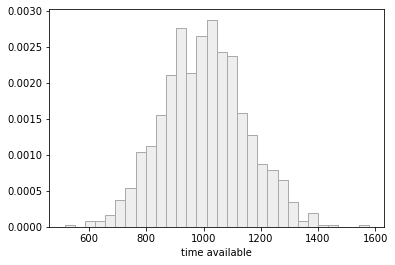

In [26]:
# avaible_time
time_available_dist = stats.norm(1000,150)

n_samples = 1000

# we create a sample vector of demands (demand_dist was defined above), only using positive outcomes
time_available_samples = np.maximum(time_available_dist.rvs(n_samples, random_state=42),0)

count, bins, ignored = plt.hist(time_available_samples , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
plt.xlabel('time available')
plt.show()

## Uncertain Machine Time: How likely is it that our Solution is Infeasible?

The following function can be used to estimate the feasibility of a production plan:

In [20]:
def probability_production_plan_is_feasible (production_decisions, time_available_samples):
    return np.mean([2 * production_decisions[0] + production_decisions[1] <= time_available for time_available in time_available_samples])

Let's apply it to our optimal deterministic decision:

In [22]:
probability_of_feasibility =  probability_production_plan_is_feasible (production_decisions, time_available_samples)

print (f'The production plan is feasible with probability {probability_of_feasibility:.02f}')

The production plan is feasible with probability 0.51


# Ensuring Feasibility

## Enforcing Feasibility for each Scenario?

What if we want to establish feasibility for each scenario?
- the time constraint becomes: $\quad 2x_A + x_B \leq b_{T,s} \qquad \forall s \in S$
- which is equivalent to the single constraint:
 $\quad 2x_A + x_B \leq \min\limits_{s \in S} b_{T,s}$
- note that $\min\limits_{s \in S} b_{T,s}$ can be  computed **before** solving the problem

Note that this approach, sometimes called **fat solution**, 
- is extremely conservative / pessimistic 
- may lead  completely infeasible model instances in more complex cases
- depends a lot on the samples that are drawn:
  - different samples can result in very different solutions
  - more samples tend to result in more pessimistic decisions

### Ensuring Feasibility for each Scenario

If we want the model to be feasible for each scenario, we just use the minimum of the available time over all sample values.

In [27]:
# Create a new model
m = mip.Model("Belt_Production_Pessimistic")

min_time_avaible = np.min(time_available_samples)

#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# we change this variable
m += sum (time_consumption[b]*production[b] for b in belt_types) <= min_time_avaible 
m += sum (production[b] for b in belt_types) <= leather_available 

m.optimize()

production_decisions = [production[b].x for b in belt_types]
for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

Production belt 0: 0.0
Production belt 1: 513.8098989896391
Total Profit: 770.7148484844587


### Ensuring Feasibility for each Scenario: Evaluating the Solution

We may evaluate the solution, and of course it should be feasible

In [28]:
probability_of_feasibility =  probability_production_plan_is_feasible (production_decisions, time_available_samples)

print (f'The production plan is feasible with probability {probability_of_feasibility:.02f}')

The production plan is feasible with probability 1.00


We may also evaluate it using a new sample, resulting in a so-called *out-of-sample* evaluation

In [32]:
probability_of_feasibility =  probability_production_plan_is_feasible (production_decisions, time_available_dist.rvs(10000, random_state=4))

print (f'The production plan is feasible with probability {probability_of_feasibility}')

The production plan is feasible with probability 0.9994


**Exercise:** 

Experiment with different samples of the same size and samples of different sizes and see the effects on the decisions and on the profit!

# Chance Constraints

## Chance Constraints: Key Idea

**Key Idea:**
- 100% feasibility is often very expensive
- instead ensure that the probability of feasibility is $\geq \alpha$

Formally expressed, given a constraint $C$, a **chance constraint** can be written as:

$$P(C\: \mathrm{holds}) \geq \alpha$$

In our example, given $B_T$ as the random variable for available time:

$$P(2x_A + x_B \leq B_T) \geq \alpha$$

- if only a single constraint is affected by uncertainty, a single
  chance constraint ensures that the solution is feasible with a probability $\geq \alpha$
- if more constraints are uncertain, we have **joint chance constraints** 

## How to Model a Chance Constraint?

Given that $B_T$ is a random variable and $\alpha$ is
the desired probability of feasibility, how can we model the chance constraint:

$$P(2x_A + x_B \leq B_T) \geq \alpha$$

**Key Idea:**
    
Assume that we have a set $S$ of scenarios. Then we can approximate
the chance constraint by ensuring that the constraint is violated in
at most $(1-\alpha)|S|$ scenarios
- we can achieve this by sorting the scenarios from the most to the least restricting  and
- taking the value $b^{\alpha}_{T}$ below which $(1-\alpha)|S|$
  values fall and using it in the right hand side of the constraint:


$$2x_A + x_B \leq b^{1-\alpha}_{T}$$

- this way, there are at most $\alpha |S|$ scenarios violating the  constraint 
- for example, in case of $\alpha=0.95$ and $|S|$ = 1000,
  $b^{1-\alpha}_{T,s}$ is the 51th-smallest value from all scenarios




## Chance Constraints Using Quantiles

- observe that the value $b^{1-\alpha}_{T}$ corresponds to the
  $(1-\alpha)$ quantile of the sample distribution
- thus, if we have a random distribution for which we can compute the
  $(1-\alpha)$ quantile directly (without sampling), we can use it without resorting to sampling
- for our example, the full model looks as follows:


$\begin{align*}
        \max \;          2x_A +1.5x_B  \\                  
        \text{s.t.} \;   2x_A + x_B &\leq b^{1-\alpha}_{T} \\
		    	   x_A + x_B &\leq 800 \\
		    	   0 \leq x_A &\leq 400 \\
		    	   0 \leq x_B &\leq 700 
\end{align*}$

- observe that the model does *not* involve scenarios but has
  the same size as the deterministic model - we only replace $b_T$ with $b^{1-\alpha}_T$.


### Individual Chance Constraints

Given that we have a single chance constraint, we can ensure feasibility with probability $\alpha$ by replacing the uncertain right hand side parameter with the $1-\alpha$-quantile of the distribution.



In [33]:
# Create a new model
m = mip.Model("Belt_Production_Single_Chance_Constraint")


alpha = 0.95

#in scipy stats, we get the quantile using the function ppf (inverse cumulative distribution function)
# we may also get the quantile from the set of samples!
time_available_quantile = time_available_dist.ppf(1-alpha)

#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# we change this variable
m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available_quantile
m += sum (production[b] for b in belt_types) <= leather_available 

### Individual Chance Constraints: Solving and Evaluating the Model

In [34]:
m.optimize()

production_decisions = [production[b].x for b in belt_types]

for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

Production belt 0: 26.635977978639573
Production belt 1: 700.0
Total Profit: 1103.2719559572793


Let us use Monte-Carlo simulation to verify:

In [35]:
      # let's evaluate feasibility using sampling!
probability_of_feasibility_from_sampling =  probability_production_plan_is_feasible (production_decisions, time_available_dist.rvs(50000, random_state=42))

print (f'Using Monte Carlo, the production plan is feasible with probability {probability_of_feasibility_from_sampling :.02f}')

Using Monte Carlo, the production plan is feasible with probability 0.95


# Joint Chance Contraints

## But: What Happens in Case of  Multiple Uncertain Constraints?

**Let us now assume that both resource constraints are uncertain:**
- no only time, but also leather capacity is affected by uncertainty, e.g. due
  to quality issues, represented by the random variable $B_L$
- as in the time case, there is no second-stage / recourse decision is available

**Question:** How can we ensure that our plan is feasible with a probability of $\alpha$?

- more formally, how can we ensure the so-called *joint chance constraint*

$$ P \left( \begin{array}{r}  2 x_A + x_B \leq B_T \\  x_A + x_B \leq B_L \end{array} \right) \geq \alpha$$ 


## Uncertain Leather Availability: Probability Distribution

We assume that leather availability is normally distributed:

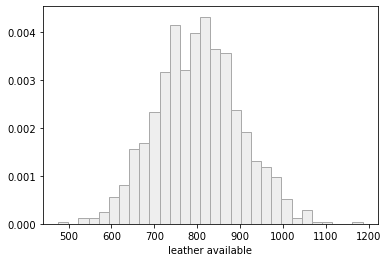

In [37]:
# available leather
leather_available_dist = stats.norm(800,100)


# we create a sample vector of demands (demand_dist was defined above), only using positive outcomes
leather_available_samples = np.maximum(leather_available_dist.rvs(n_samples, random_state=42),0)

count, bins, ignored = plt.hist(leather_available_samples , bins=30, density=True, color='#EEEEEE', edgecolor="#AAAAAA")
plt.xlabel('leather available')
plt.show()

## What about using two single chance constraints to model the joint chance constraint?


We may enforce that

$P(2x_A + x_B \leq B_{T}) \geq \alpha$ **and**  $P(x_A + x_B \leq B_{L}) \geq \alpha$ 


by the following constraints:

 \begin{align*}
  2x_A + x_B &\leq b^{1-\alpha}_{T} \\
   x_A + x_B &\leq b^{1-\alpha}_{L} 
\end{align*}



**Does this imply that the problem is feasible with  probability  $\alpha$?**
- Let's check in Python

## Quantile-Based Model for Two Chance Constraints in Python

In [45]:
# Create a new model
m = mip.Model("Belt_Production_Single_Chance_Constraint")
m.verbose=1
belt_types = np.arange(2)
profit_contribution = [2, 1.5]
time_consumption = [2, 1]
bucks_available = [400, 700]

alpha = 0.95

#in scipy stats, we get the quantile using the function ppf (inverse cumulative distribution function)
# we may also get the quantile from the set of samples!
time_available_quantile = time_available_dist.ppf(1-alpha)
leather_available_quantile = leather_available_dist.ppf(1-alpha)


#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# we change this variable
m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available_quantile
m += sum (production[b] for b in belt_types) <= leather_available_quantile

m.optimize()
production_decisions = [production[b].x for b in belt_types]

for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )


Production belt 0: 117.7573186524263
Production belt 1: 517.7573186524265
Total Profit: 1012.1506152834925


## Quantile-Based Model for Two Chance Constraints: Evaluation in Python

- in our model, we built the two constraints with $\alpha=0.95$
- how high is the probability that the solution is feasible with respect to both constraints?


In [51]:


print(f'We want to ensure feasibility with probability {alpha}')


def probability_production_plan_is_feasible_time_and_leather  (production_decisions, time_available_samples, leather_available_samples):
    n_samples = time_available_samples.size
    feasible_samples = np.array([2 * production_decisions[0] + production_decisions[1] <= time_available_samples[s] 
                                 and production_decisions[0] + production_decisions[1] <= leather_available_samples[s] for s in range(n_samples)])
    return np.mean(feasible_samples)

n_samples_for_evaluation = 5000
samples_time = time_available_dist.rvs(n_samples_for_evaluation)
samples_leather = leather_available_dist.rvs(n_samples_for_evaluation)

probability_of_feasibility_from_sampling = probability_production_plan_is_feasible_time_and_leather (production_decisions, samples_time, samples_leather )


print (f'Based on a Monte-Carlo approximation the production plan is feasible with probability {probability_of_feasibility_from_sampling :.02f}')


We want to ensure feasibility with probability 0.95
Based on a Monte-Carlo approximation the production plan is feasible with probability 0.90


## Using Multiple Individual Chance Constraints?

As we learned in our example, in general, given a set of $n$ constraints affected by uncertainty and
a desired feasibility probability $\alpha$, the *joint chance
constraint* 

$$P( C_j \: \mathrm{holds} \quad \forall j=1\ldots n) \geq \alpha$$ 

is **not** enforced by using a set of single chance constraints of the form

$$P( C_j \: \mathrm{ holds} ) \geq \alpha \quad \forall j=1\ldots n$$


**Question**: How can we enforce a such joint chance constraint?
- note that in case of multiple uncertain constraints, the scenarios
  can no longer be ordered according to strictness of constraints
- for example, given two scenarios in the belt production case study,
  one may have a smaller $b_T$ and the other a smaller $b_L$


# Using Binary Variables for Modelling Joint Chance Constraints

## Modeling Chance Constraints using Scenarios and Binary Variables

**Key Idea: Let the solver decide which scenarios should hold**

- introduce a binary variable $y_s$ for each scenario $s \in S$:
  - $y_s = 0$ means that in scenario $s$, all uncertain constraints hold
  - $y_s = 1$ means that in scenario $s$, at least one constraint may be violated

- introduce a constraint that ensures that the total probability of
  all scenarios for which $y_s = 1$ is $\leq 1-\alpha$:
  $$\sum_{s \in S} p_s y_s \leq 1-\alpha$$

- introduce a "scenario realization" for each uncertain constraint
  and each scenario $s$ and link that constraint to $y_s$ to switch it on or off

 \begin{align*}
2x_A + x_B &\leq b_{T,s} + M_T y_s &\forall s \in S\\
 x_A + x_B &\leq b_{L,s} + M_L y_s &\forall s \in S
\end{align*}



## The Model with Joint Chance Constraints

**Sets**
- $S$: scenarios
   
**Decision Variables:**
- $x_i$: number of belts to produce from type $i$
- $y_s$: binary indicator variable for infeasibility in scenario $s$


**Parameters:**
- $p_s$: probability of scenarios $s$
- $b_{r,s}$: availability from resource $r$ (time, leather) in scenario $s$
- $M_r$: big-M value for resource $r$ used to switch off constraint



\begin{align*}
        \max \;          2x_A +1.5x_B  \\                  
        \text{s.t.} \;   2x_A + x_B &\leq b_{T,s} + M_T y_s &\forall s \in S\\
		    	   x_A + x_B &\leq b_{L,s} + M_L y_s &\forall s \in S\\
			   \sum_{s \in S} p_s y_s &\leq 1-\alpha \\
		    	   0 \leq x_A &\leq 400 \\
		    	   0 \leq x_B &\leq 700 \\
			   y_s &\in \{0,1\} &\forall s \in S
\end{align*}




## The Model with Joint Chance Constraints in Python

In [57]:
alpha = 0.95
n_scenarios = 750
scenarios = np.arange(n_scenarios)
time_available = time_available_dist.rvs(n_scenarios, random_state=5)
leather_available = leather_available_dist.rvs(n_scenarios,  random_state=7)

In [58]:
m = mip.Model("Belt_Production_Joint_Chance_Constraints")

#probability of each scenario
prob = np.full((n_scenarios), 1.0/n_scenarios)


#bigM is used for switching off constraints by adding it to the resource capacity in a scenario
#if it is chosen as difference between the max and min capacity, it is definitely large enough to switch off the constraint
bigM = [max(time_available)-min(time_available),max(leather_available)-min(leather_available)]

#decision variables
production = [m.add_var(name= f"production{b}", lb=0, ub=bucks_available[b]) for b in belt_types]

#y-variable
is_scenario_violated = [m.add_var(name=f"is_feasible{s}", var_type=mip.BINARY ) for s in scenarios]

m.objective = maximize(sum(profit_contribution[b] * production[b] for b in belt_types))

# one set of constraints per scenario
for s in scenarios:
    m += sum (time_consumption[b]*production[b] for b in belt_types) <= time_available[s] + bigM[0]*(is_scenario_violated[s])
    m += sum (production[b] for b in belt_types) <= leather_available[s] + bigM[1]*(is_scenario_violated[s])

# ensure that the right number of scenarios hold
m += sum(prob[s]*is_scenario_violated[s] for s in scenarios) <= 1-alpha 

## The Model with Joint Chance Constraints In Python


In [59]:
from time import time

start_time = time()
m.optimize()
print(f"Solution time: {time()-start_time} seconds")

production_decisions = [production[b].x for b in belt_types]
for b in belt_types:
    print(f'Production belt {b}: {production[b].x}')
print(f'Total Profit: {m.objective_value}' )

Solution time: 34.06522989273071 seconds
Production belt 0: 114.67625394947993
Production belt 1: 493.86972165175894
Total Profit: 970.1570903765983


Let us now evaluate the probability of having an infeasible model.

- first, using the same 500 samples we used in the model

In [61]:
print(f'We want to ensure feasibility with probability {alpha}')
probability_of_feasibility_from_sampling = probability_production_plan_is_feasible_time_and_leather (production_decisions, time_available, leather_available)

print (f'Using Monte Carlo for the samples used in the optimization, the production plan is feasible with probability {probability_of_feasibility_from_sampling :.02f}')

We want to ensure feasibility with probability 0.95
Using Monte Carlo for the samples used in the optimization, the production plan is feasible with probability 0.95


- and then, using 5000 new sample (out-of-sample evaluation)

In [68]:
n_samples_for_evaluation = 100000
probability_of_feasibility_from_sampling = probability_production_plan_is_feasible_time_and_leather (production_decisions, time_available_dist.rvs(n_samples_for_evaluation), leather_available_dist.rvs(n_samples_for_evaluation))

print (f'Using Monte Carlo with different samples, the production plan is feasible with probability {probability_of_feasibility_from_sampling :.03f}')

Using Monte Carlo with different samples, the production plan is feasible with probability 0.941


# Exercise: Capacity Planning Case Study - Reaching A Certain Profit with a Desired Probability

## Exercise: Capacity Planning Case Study


- Here you once again find the implementation of the capacity planning case study, this time with the modification from last week for obtaining an approximation of a profit distribution


In [69]:
demand_dist = stats.norm(100,25)
n_samples = 500

# we create a sample vector of demands (demand_dist was defined above), only using positive outcomes
demand_sample = np.maximum(demand_dist.rvs(n_samples),0)
prob = np.full((n_scenarios), 1/n_scenarios)

m = mip.Model("Capacity_Planning_Stochastic")

#in stochastic programming, we call the samples scenarios
n_scenarios = n_samples
scenarios = np.arange(n_scenarios) # set of scenarios

#parameters
installation_cost = 30
contribution_margin = 40

#decision variables
capacity =  m.add_var(name="capacity", lb=0)

production = [m.add_var(name=f"production{s}", lb= 0) for s in scenarios]

## this is the new variable
profit = [m.add_var(name=f"profit{s}",  lb=-np.inf) for s in scenarios]

m.objective =  maximize( sum(prob[s] * profit[s] for s in scenarios)) 

for s in scenarios:   
    m += profit[s] == -installation_cost*capacity + contribution_margin * production[s] # computes the profit for scenario s
    m += production[s] <= demand_sample[s]
    m += production[s] <= capacity 

m.optimize()

print(f'Capacity decision: {capacity.x:.02f}')
print(f'Expected Total Profit: {m.objective_value:.02f}' )

profit_samples = np.array( [ profit[s].x for s in scenarios ])



Capacity decision: 84.27
Expected Total Profit: 454.73


## Exercise: Capacity Planning Case Study: Tasks

- what is the probability that the profit exceeds 500?


- modify the model in a way that we obtain a profit exceeding 500 with a probability of 90%
- hint: use the basic idea of using binary variables for modeling (joint) chance constraints!

## Summary

In the two parts of this meeting, we dealt with approaches for avoiding undesired outcomes:

#### Part I:  Risk Orientation / Decision-Making as Shaping Distributions
- Decision Making under Uncertainty as Shaping Distributions
- Comparing Distributions: Stochastic Dominance
- Shaping Distributions by Incorporating Risk Attitude into Decision / Optimization Models

#### Part II: Feasibility Guarantees by Chance-Constrained Programming
- Feasibility Issues in Single-Stage Problems under Uncertainty
- Single Chance Constraints
- Joint Chance Constraints

